-----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Librerias

In [1]:
import pandas as pd
import json
from collections import defaultdict
import re
import numpy as np
from utils.utilities import Tiempo
import utils.dataExtraction
import statistics
import keyword
import re
import matplotlib.pyplot as plt
import mplcursors

import xml.etree.ElementTree as ET

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que extrae los timestamps de inicio y fin de cada intentos de nivel
#### También extrae las estrellas obtenidas en cada intentos y cuantas veces se han intentado todos los niveles por cada jugador 

In [2]:
def extraerTiemposPorNivelJugador(rawData):
    
    tiempos = defaultdict(defaultdict)
    intentosNecesarios = defaultdict(defaultdict)
    
    erLevel = re.compile(r'\blevel$\b')
    erIdLevel = re.compile(r'/')
    
    erInitialized = re.compile(r'\binitialized$\b')
    erCompleted = re.compile(r'\bcompleted$\b')
    
    for evento in rawData:
        verb = evento["verb"]["id"]
        obj = evento["object"]["definition"]["type"]
        name = evento["actor"]["name"]
        timestamp = evento["timestamp"]
        objectId = evento["object"]["id"]
        
        if erLevel.search(obj): #Si el objeto de la acción es un nivel
            levelCode = erIdLevel.split(objectId)[-1]
            if levelCode != "editor_level":
                if erInitialized.search(verb): #Si la acción es inicio o reinicio
                    if "result" in evento: #Significa que ha iniciado el nivel desde el menu
                        if levelCode in tiempos[name]:
                            intentosNecesarios[name][levelCode].append({"intentos" : 1, "success" : False})
                            tiempos[name][levelCode].append({"ini" : timestamp, "fin" : None, "stars" : ""})
                        else:
                            intentosNecesarios[name][levelCode] = [{"intentos" : 1, "success" : False}]
                            tiempos[name][levelCode] = [{"ini" : timestamp, "fin" : None, "stars" : ""}]
                    else:
                        intentosNecesarios[name][levelCode][-1]["intentos"] += 1
                elif erCompleted.search(verb):
                    if evento["result"]["score"]["raw"] > 0 :
                        if levelCode in tiempos[name]:
                            intentosNecesarios[name][levelCode][-1]["success"] = True
                            tiempos[name][levelCode][-1]["fin"] = timestamp
                            tiempos[name][levelCode][-1]["stars"] = evento["result"]["score"]["raw"]

                    elif evento["result"]["score"]["raw"] == -1:
                        if levelCode in tiempos[name]:
                            tiempos[name][levelCode][-1]["fin"] = timestamp
                            tiempos[name][levelCode][-1]["stars"] = evento["result"]["score"]["raw"]
    
    return {"tiempos" : tiempos, "intentosNecesarios" : intentosNecesarios}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que resta los timestamps de inicio y fin de cada intento de nivel para sacar la diferencia de tiempo

In [3]:
def tiempoPorNiveles_Jugador(data):
    tiemposJugados = defaultdict(defaultdict)
    for player in data:
        for level in data[player]:
            for times in data[player][level]:
                if times["fin"] != None: #Si no se aborto el intento del nivel
                    timeDifference = Tiempo(times["ini"], times["fin"])
                    if level in tiemposJugados[player]:
                        tiemposJugados[player][level].append({"time" : timeDifference, "stars" : times["stars"]})
                    else:
                        tiemposJugados[player][level] = [{"time" : timeDifference, "stars" : times["stars"]}]
    return tiemposJugados

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que devuelve el tiempo medio necesario para completar un nivel y un diccionario con el tiempo empleado por cada jugador hasta completar el nivel
(El tiempo necesario para cada jugador es la suma de todos los tiempos hasta conseguir completar el nivel)
* También devuelve la media de estrellas y una lista de los niveles ordenados

In [4]:
#TAMBIEN DEVUELVE EL TIEMPO INDIVIDUAL DE CADA JUGADOR PARA COMPLETAR CADA NIVEL
def getMediaTiempoPorNivel(tiempos, soloPrimerExito = True, tiemposOrdenados = False):
    medias = defaultdict(list)
    mediasEstrellas = defaultdict(list)
    tiempoCompletarNivelIndividual = defaultdict(defaultdict)
    
    for player in tiempos:
        for level in tiempos[player]:
            tAux = Tiempo("0s")
            for t in tiempos[player][level]:
                if t["stars"] != -1:
                    if level in medias:
                        medias[level].append(int(tAux + t["time"]))
                        mediasEstrellas[level].append(int(t["stars"]))
                    else:
                        medias[level] = [int(tAux + t["time"])]
                        mediasEstrellas[level] = [int(t["stars"])]
                        
                    tiempoCompletarNivelIndividual[player][level] = tAux + t["time"]
                    if soloPrimerExito:
                        break
                elif t["stars"] == 0:
                    print("ALERTA")
                else:
                    tAux += t["time"]
    for m in medias:
        medias[m] = Tiempo(str(int(round(statistics.mean(medias[m]), 0))) + "s")
        
    for m in mediasEstrellas:
        mediasEstrellas[m] = statistics.mean(mediasEstrellas[m])
    
    listaNiveles = medias.keys()
    
    if tiemposOrdenados:
        medias = sorted(medias.items(), key=lambda x: x[1])
        mediasEstrellas = sorted(mediasEstrellas.items(), key=lambda x: x[1])
    else:
        medias = list(medias.items())
        mediasEstrellas = list(mediasEstrellas.items())
    
    return {"mediaTiempos" : medias, "mediaEstrellas" : mediasEstrellas, "listaNiveles" : listaNiveles, "tiemposIndividuales" : tiempoCompletarNivelIndividual}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Devuelve un diccionario con clave: id Jugador y valor: ultimo nivel alcanzado

In [5]:
def getUltimoNivelAlcanzado(tiempos):
    ultNivel = defaultdict()
    for player in tiempos:
        for level in tiempos[player]:
            ultNivel[player] = level
    return ultNivel

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Devuelve los intentos necesarios de cada jugador para completar un nivel al igual que los intentos medios

In [6]:
#TAMBIEN DEVUELVE LOS INTENTOS INDIVIDUALES DE CADA JUGADOR PARA COMPLETAR CADA NIVEL
def getIntentosMedios_HastaCompletarNivel(intentosNecesarios, intentosOrdenados = False):
    intentosMedios = defaultdict(list)
    intentosCompletarNivelIndividual = defaultdict(defaultdict)
    
    for name in intentosNecesarios:
        for level in intentosNecesarios[name]:
            cont = 0
            for i in intentosNecesarios[name][level]:
                cont += i["intentos"]
                if i["success"] == True:
                    intentosMedios[level].append(cont)
                    intentosCompletarNivelIndividual[name][level] = cont
                    break
            
    for level in intentosMedios:
        intentosMedios[level] = round(statistics.mean(intentosMedios[level]), 2)
    
    if intentosOrdenados:
        intentosMedios = sorted(intentosMedios.items(), key=lambda x: x[1])
    else:
        intentosMedios = list(intentosMedios.items())
    return {"intentosMedios" : intentosMedios, "intentosIndividual" : intentosCompletarNivelIndividual}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Transforma un diccionario de diccionarios en un diccionario de arrays
* Se utiliza para tener una lista de todos los tiempos de los usuarios cuando tenemos un diccionario dentro de otro con primera clave nombre usuario y segunda clave codigo del nivel

In [7]:
def extraerArray(my_dict):
    nested_keys = []
    nested_values = []

    for k, v in my_dict.items():
        for nested_k, nested_v in v.items():
            nested_keys.append(nested_k)
            nested_values.append(nested_v)

    # create a dictionary with keys as the values of the nested_keys array
    nested_dict = defaultdict(list)
    for key, value in zip(nested_keys, nested_values):
        nested_dict[key].append(value)
    
    return nested_dict

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Recibe un diccionario con clave nivel y valor una lista de tiempos y parsea los tiempos a integer

In [8]:
def parseTiemposDictToInteger(data_dict):
    parsed_dict = {}

    for key, value in data_dict.items():
        parsed_list = []
        for element in value:
            parsed_list.append(int(element))
        parsed_dict[key] = parsed_list

    return parsed_dict

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que genera los boxplots recibiendo un diccionario con clave nivel y valor una lista de enteros

In [9]:
def create_boxplots(data_dict):
    # Group levels by category
    category_dict = {}
    for level, data in data_dict.items():
        category = level.split('_')[0]
        if category in category_dict:
            category_dict[category].append(data)
        else:
            category_dict[category] = [data]
    
    # Create boxplots for each category and add relevant information
    boxplots = []
    labels = []
    for i, (category, data_list) in enumerate(category_dict.items()):
        fig, ax = plt.subplots()
        bp = ax.boxplot(data_list, showfliers=True, patch_artist=True, flierprops={'marker': '+', 'markerfacecolor': '#738FA7'})
        ax.set_title(category)

        color = '#738FA7'
        for patch in bp['boxes']:
            patch.set_facecolor(color)
        
        boxplots.append(bp)
        labels.append(category)
    
    # Set tick labels
    fig, ax = plt.subplots()
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelrotation=45)
    
    return boxplots


In [10]:
def getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles):
    cuantosHanLlegadoAlNivel = defaultdict()
    
    ultNivelCopia = ultNivelCompletado.copy()

    #Contamos cuanta gente ha llegado hasta cada nivel
    for nivel in niveles:
        cuantosHanLlegadoAlNivel[nivel] = len(ultNivelCopia)
        
        keys_to_delete = [k for k, v in ultNivelCopia.items() if v == nivel]
        for k in keys_to_delete:
            del ultNivelCopia[k]

    return cuantosHanLlegadoAlNivel

In [11]:
def generateChartNivelesAlcanzados(niveles, ultNivelCompletado):
    cuantosHanLlegadoAlNivel = getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles)

    category_dict = {}
    for level, value in cuantosHanLlegadoAlNivel.items():
        category = level.split('_')[0]
        level_number = int(level.split('_')[-1])
        if category in category_dict:
            category_dict[category].append((level_number, value))
        else:
            category_dict[category] = [(level_number, value)]
    for category, levels in category_dict.items():
        category_dict[category] = sorted(levels, key=lambda x: x[0])

    # Select the last level for each category
    last_levels = {}
    for category, levels in category_dict.items():
        last_level = levels[-1][0]
        last_levels[category] = levels[-1][1]

    # Create bar chart and add labels
    fig, ax = plt.subplots()
    ax.bar(last_levels.keys(), last_levels.values(), color="#738FA7")
    ax.set_xticklabels(last_levels.keys(), rotation=45, ha='right')
        
    plt.show()

In [12]:
def getChartPorcentajeCategorias(niveles, ultNivelCompletado, total_players):

    cuantosHanLlegadoAlNivel = getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles)

    ultimoNivelCat = {}
    for level in niveles:
        category = level.split("_")[0]
        ultimoNivelCat[category] = level
    
    percentages = {}
    for ultNivel in ultimoNivelCat.values():
        percentages[ultNivel] = (cuantosHanLlegadoAlNivel[ultNivel]/total_players)*100
    
    fig, ax = plt.subplots()
    ax.bar(range(len(percentages)), list(percentages.values()), align='center', color="#738FA7")
    ax.set_xticks(range(len(percentages)))
    ax.set_xticklabels(map(lambda c: c.split("_")[0], list(percentages.keys())), rotation=45, ha='right')
    ax.set_ylim((0, 100))
    ax.set_ylabel('Porcentaje Jugadores')
    ax.set_xlabel('Categorías')
    ax.set_title('Categorías Superadas')
    
    return ax

In [13]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = None

In [14]:
JSONFile = open('./data/trazasOrdenadas.json')
rawData = json.load(JSONFile)
JSONFile.close()

resultados_Tiempos_Nivel_Jugador = extraerTiemposPorNivelJugador(rawData)

In [15]:
tiemposIntentosJugadores = tiempoPorNiveles_Jugador(resultados_Tiempos_Nivel_Jugador["tiempos"])
#pd.DataFrame(tiemposIntentosJugadores)
#pd.DataFrame(resultados_Tiempos_Nivel_Jugador["intentosNecesarios"])

In [16]:
soloPrimerExito = True
tiemposOrdenados = False
tiemposMedios = getMediaTiempoPorNivel(tiemposIntentosJugadores, soloPrimerExito, tiemposOrdenados)
#pd.DataFrame(tiemposMedios["mediaTiempos"])
#pd.DataFrame(tiemposMedios["mediaEstrellas"])
#pd.DataFrame(tiemposMedios["listaNiveles"])
#pd.DataFrame(tiemposMedios["tiemposIndividuales"])

In [17]:
ultNivelAlcanzado = getUltimoNivelAlcanzado(tiemposMedios["tiemposIndividuales"])
#print(ultNivelAlcanzado)

In [18]:
intentosOrdenados = False
intentosMedios_Individual = getIntentosMedios_HastaCompletarNivel(resultados_Tiempos_Nivel_Jugador["intentosNecesarios"], intentosOrdenados)
#pd.DataFrame(intentosMedios_Individual["intentosMedios"])
#pd.DataFrame(intentosMedios_Individual["intentosIndividual"])

In [19]:
tiemposList = extraerArray(tiemposMedios["tiemposIndividuales"])
intentosList = extraerArray(intentosMedios_Individual["intentosIndividual"])
#pd.DataFrame.from_dict(tiemposList, orient='index').transpose()
#pd.DataFrame.from_dict(intentosList, orient='index').transpose()

C:\Users\david\AppData\Local\Temp\ipykernel_13876\3774671035.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(last_levels.keys(), rotation=45, ha='right')


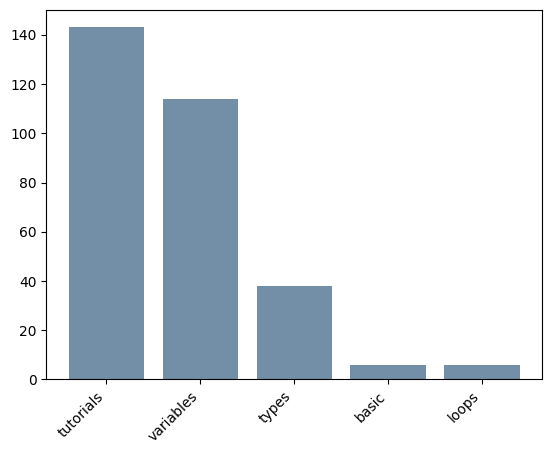

In [20]:
generateChartNivelesAlcanzados(tiemposMedios["listaNiveles"], ultNivelAlcanzado)

<Axes: title={'center': 'Categorías Superadas'}, xlabel='Categorías', ylabel='Porcentaje Jugadores'>

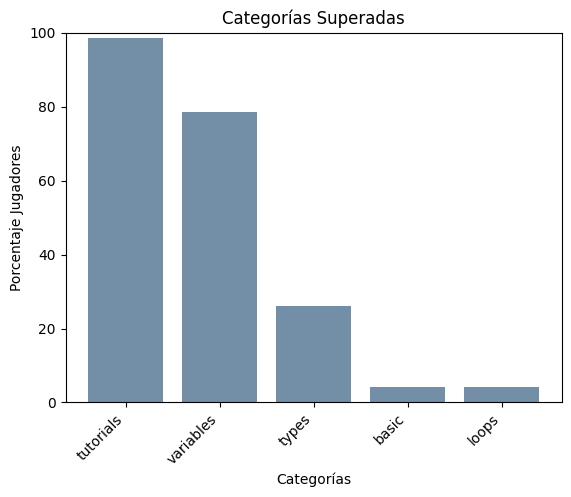

In [21]:
getChartPorcentajeCategorias(tiemposMedios["listaNiveles"], ultNivelAlcanzado, len(ultNivelAlcanzado))

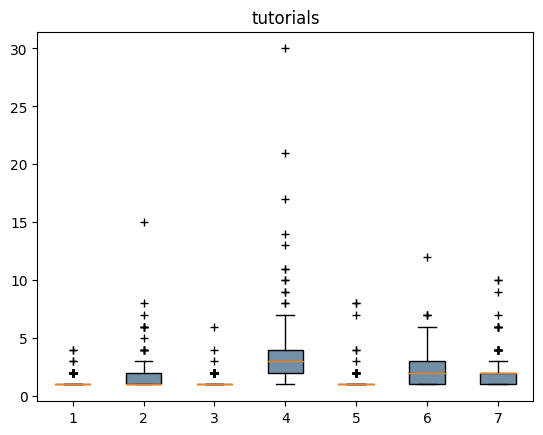

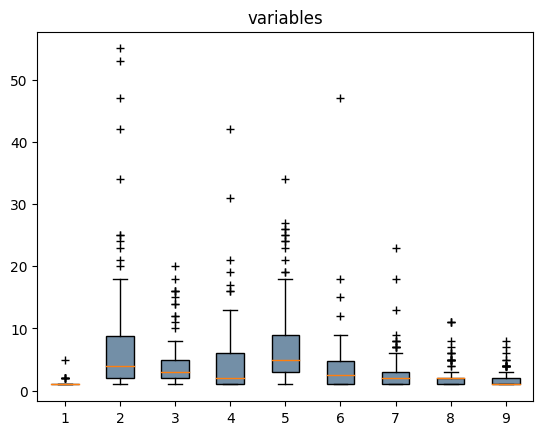

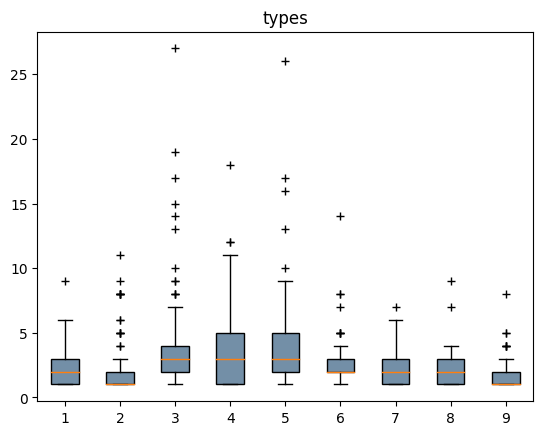

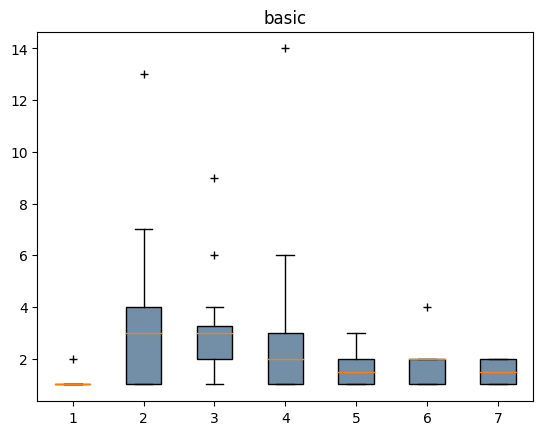

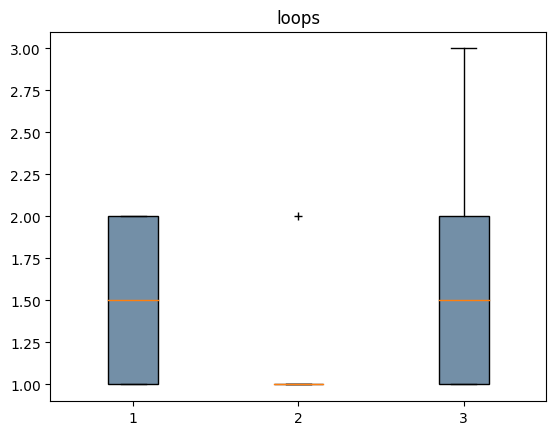

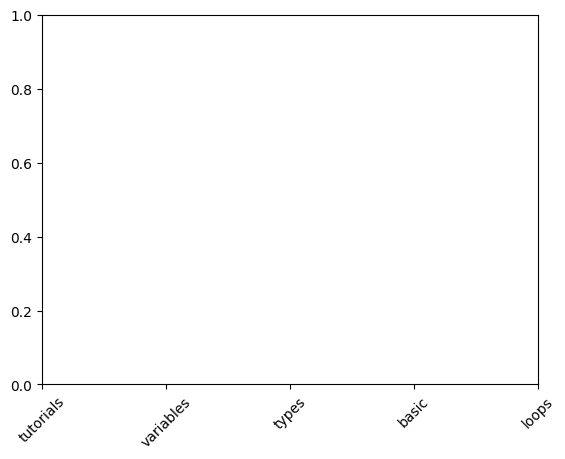

In [22]:
boxplotsIntentos = create_boxplots(intentosList)

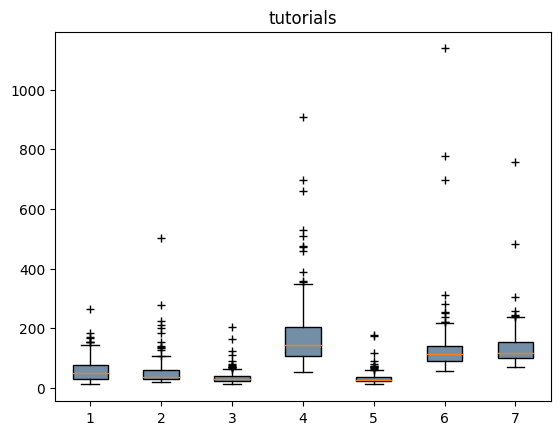

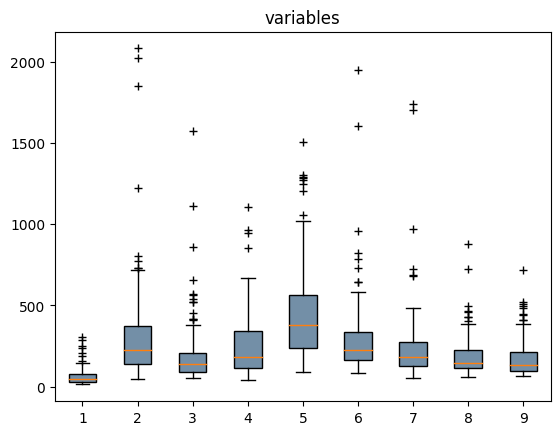

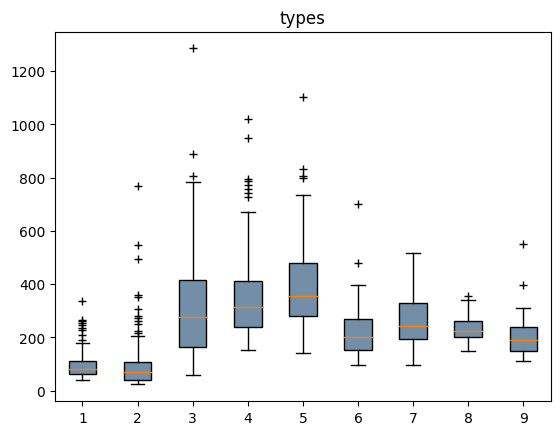

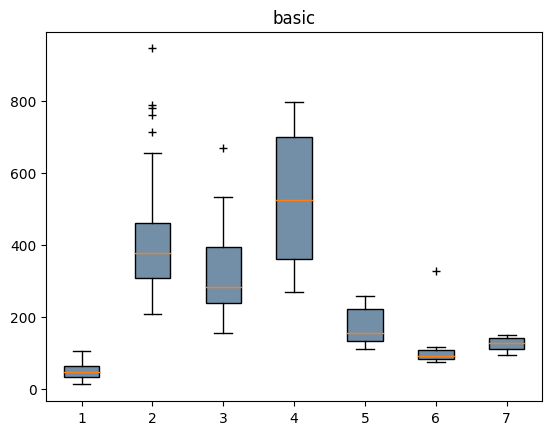

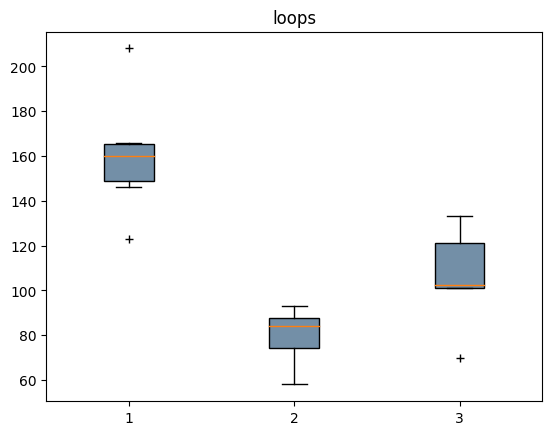

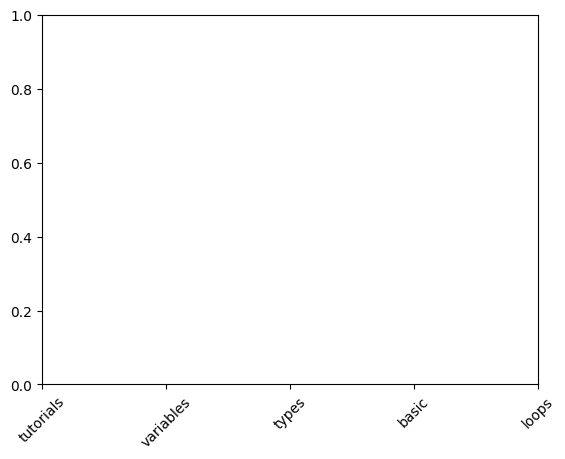

In [23]:
boxplotsTiempos = create_boxplots(parseTiemposDictToInteger(tiemposList))

In [24]:
import plotly.express as px

def create_boxplots2(data_dict):
    categorias = defaultdict(defaultdict)
    for d in data_dict:
        categorias[d.split("_")[0]][d] = data_dict[d]


    boxplots = []
    for c in categorias:
        df = pd.DataFrame.from_dict(categorias[c], orient="index").transpose()
        df_melt = pd.melt(df.reset_index(), id_vars=["index"], value_vars=list(categorias[c].keys()))
        df_melt.columns = ["index", c, "Intentos"]

        fig =px.box(df_melt, x=c, y="Intentos")
        fig.write_json("./plots/"+c+".json")
        fig.show()
        boxplots.append(fig)
        
    
    return boxplots    

boxs= create_boxplots2(intentosList)

FileNotFoundError: [Errno 2] No such file or directory: 'plots\\tutorials.json'

## Dataframes pagina web

In [ ]:
df_tiempo = pd.DataFrame(tiemposMedios["mediaTiempos"])
df_estrellas = pd.DataFrame(tiemposMedios["mediaEstrellas"])
df_intentos = pd.DataFrame(intentosMedios_Individual["intentosMedios"])

In [ ]:
def combinar_dataframes(df_tiempo, df_intentos, df_estrellas, categoria):
    # Asignar nombres a las columnas sin nombre
    df_tiempo.columns = ['nivel', 'tiempo_medio']
    df_intentos.columns = ['nivel', 'intentos_medios']
    df_estrellas.columns = ['nivel', 'estrellas_medias']

    # Combinar los dataframes de tiempo y de intentos
    df_tiempo_intentos = df_tiempo.merge(df_intentos, on='nivel')

    # Combinar el dataframe anterior con el de estrellas
    df_final = df_tiempo_intentos.merge(df_estrellas, on='nivel')

    # Renombrar las columnas
    df_final.columns = ['nivel', 'tiempo_medio', 'intentos_medios', 'estrellas_medias']

    # Filtrar los niveles por categoría
    df_final = df_final[df_final['nivel'].str.startswith(categoria)]

    # Devolver el dataframe combinado
    return df_final

In [ ]:
df_final = combinar_dataframes(df_tiempo, df_intentos, df_estrellas, "tutorials")
df_final

,nivel,tiempo_medio,intentos_medios,estrellas_medias
0,tutorials_1,1m,1.23,3.000000
1,tutorials_2,55s,1.90,2.923611
2,tutorials_3,37s,1.28,3.000000
3,tutorials_4,3m/2s,3.67,3.000000
4,tutorials_5,34s,1.31,2.986014
5,tutorials_6,2m/17s,2.19,2.916084
6,tutorials_7,2m/19s,2.20,2.874126


In [ ]:
def media_parametros(df_tiempo, df_intentos, df_estrellas):
     # Asignar nombres a las columnas sin nombre
    df_tiempo.columns = ['nivel', 'tiempo_medio']
    df_intentos.columns = ['nivel', 'intentos_medios']
    df_estrellas.columns = ['nivel', 'estrellas_medias']

    # Buscar la primera columna que contenga la palabra "nivel"
    columnas = df_tiempo.columns.tolist()
    for columna in columnas:
        if 'nivel' in columna:
            nivel_columna = columna
            break

    # Obtener las categorías de niveles a partir de la primera columna que contenga la palabra "nivel"
    orden_categorias = [nivel.rsplit('_', 1)[0] for nivel in df_tiempo[nivel_columna].tolist()]

    # Combinar los dataframes de tiempo, intentos y estrellas
    df_completo = df_tiempo.merge(df_intentos, on='nivel').merge(df_estrellas, on='nivel')
    
    # Separar la categoría de niveles de la columna 'nivel'
    def get_categoria(nivel):
        for categoria in orden_categorias:
            if categoria in nivel:
                return categoria
        return nivel

    df_completo['categoria'] = df_completo['nivel'].apply(get_categoria)
    
    # Convertir los tiempos a segundos
    df_completo['tiempo_medio_segundos'] = df_completo['tiempo_medio'].apply(int)
    
    # Calcular la media de los valores por categoría de niveles
    df_media = df_completo.groupby('categoria').mean().reset_index()

    # Crear una columna adicional que contenga el índice de orden original de cada categoría
    df_media['orden'] = df_media['categoria'].apply(lambda x: orden_categorias.index(x))

    # Ordenar el dataframe resultante por el índice de orden original
    df_media = df_media.sort_values('orden')

    # Eliminar la columna adicional de orden
    df_media = df_media.drop('orden', axis=1)

    # Convertir los tiempos a formato minutos y segundos
    df_media['tiempo_medio_segundos'] = df_media['tiempo_medio_segundos'].apply(lambda x: str(int(x)) + "s")
    df_media['tiempo_medio_segundos'] = df_media['tiempo_medio_segundos'].apply(Tiempo)

    # Renombrar las columnas
    df_media.columns = ['Categorías', 'Intentos', 'Estrellas', 'Tiempos']
    df_media['Categorías'] = df_media['Categorías'].apply(lambda x: ' '.join([s.capitalize() for s in x.split('_')]))

    # Seleccionar las columnas que nos interesan y devolver el dataframe resultante
    return df_media[['Categorías', 'Tiempos', 'Intentos', 'Estrellas']]


In [ ]:
media_parametros(df_tiempo, df_intentos, df_estrellas)

C:\Users\David\AppData\Local\Temp\ipykernel_14988\1562682296.py:33: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Categorías,Tiempos,Intentos,Estrellas
2,Tutorials,1m/32s,1.968571,2.957119
4,Variables,4m/4s,3.862222,2.804857
3,Types,4m/5s,2.781111,2.900568
0,Basic Operators,4m/12s,2.227143,2.905290
1,Loops,1m/55s,1.446667,2.666667
